## File for spatial analysis 

4 files containing average values of each predictor for each season 


In [1]:
## convert wind speed to a single value (ignoring the direction)

import xarray as xr
import numpy as np

# Load the NetCDF file
u_data = xr.open_dataset('/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/2009_2023_climate/2009_2023_10m_u_component_of_wind_daily.nc')
v_data = xr.open_dataset('/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/2009_2023_climate/2009_2023_10m_v_component_of_wind_daily.nc')

# Calculate wind speed
wind_speed = np.sqrt(u_data['u10']**2 + v_data['v10']**2)

# Create a new dataset for wind speed
wind_speed_ds = wind_speed.to_dataset(name='wind_speed')

wind_speed_ds.to_netcdf('/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/2009_2023_climate/2009_2023_10m_wind_daily.nc')


In [ ]:
## aggregate daily files to weekly data

import xarray as xr
import os
from glob import glob

# input files and output files
input_dir = '/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/2009_2023_climate'
input_files = glob(os.path.join(input_dir, '2009_2023_*_daily.nc'))
output_dir = os.path.join(input_dir, 'weekly_data/')
os.makedirs(output_dir, exist_ok=True)

# Loop through each file, resample to weekly data, and save
for file_path in input_files:
    # Open the dataset
    ds = xr.open_dataset(file_path)
    
    # Check if the dataset contains precipitation data
    if 'precipitation' in file_path.lower():
        # Use sum for weekly precipitation
        weekly_ds = ds.resample(valid_time='1W').sum()
        print(f"Processing precipitation data: {file_path}")
    else:
        # Use mean for other datasets
        weekly_ds = ds.resample(valid_time='1W').mean()
        print(f"Processing other data: {file_path}")
    
    # Generate output file name
    base_name = os.path.basename(file_path)
    output_file_path = os.path.join(output_dir, f"weekly_{base_name}")
    
    # Save the resampled dataset
    weekly_ds.to_netcdf(output_file_path)


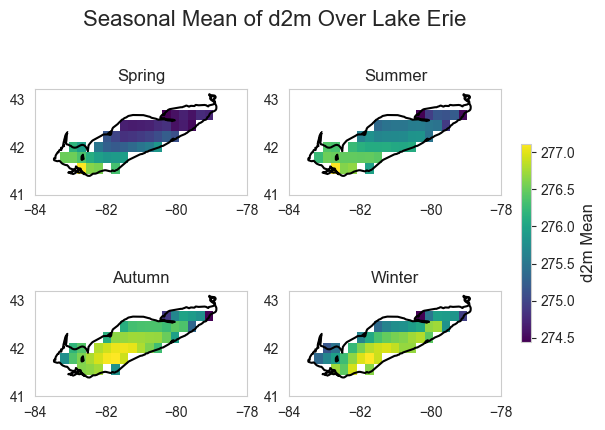

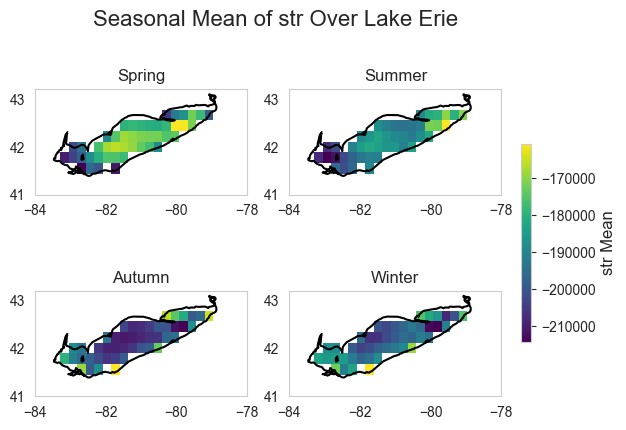

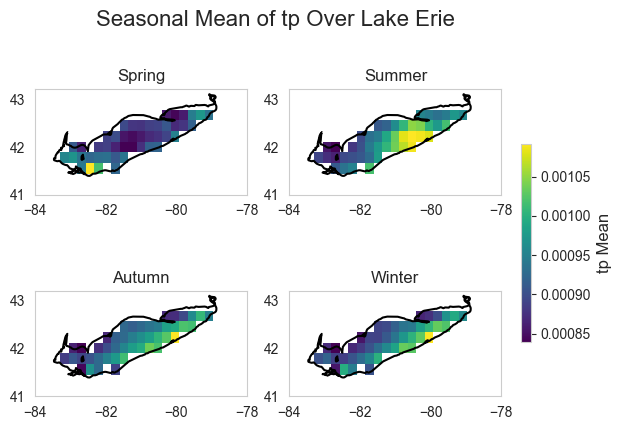

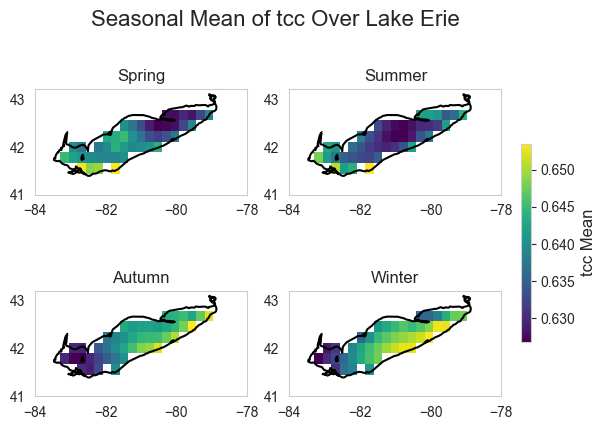

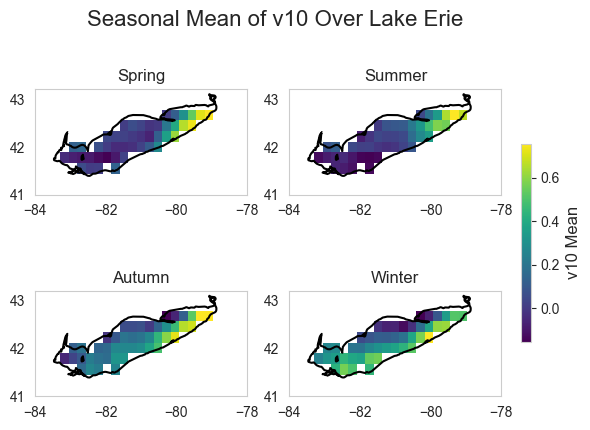

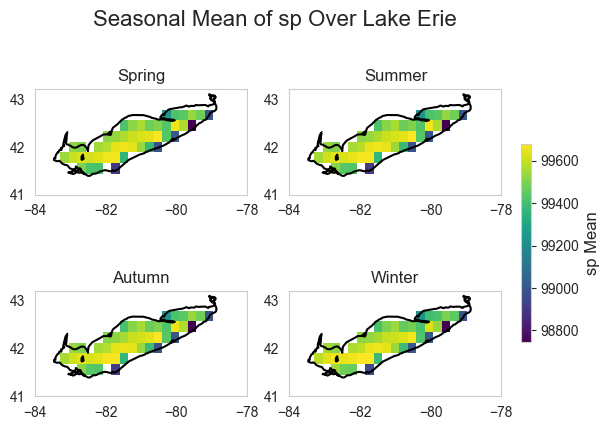

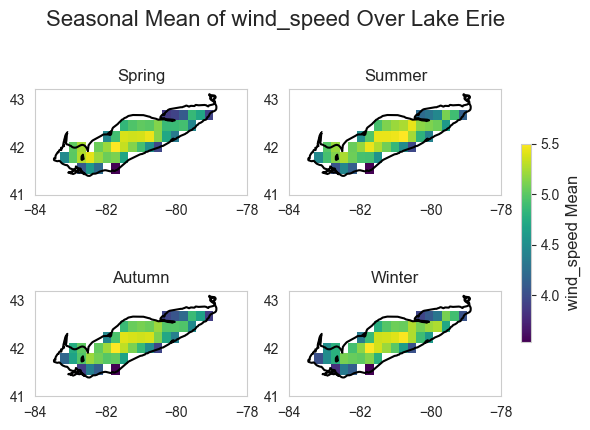

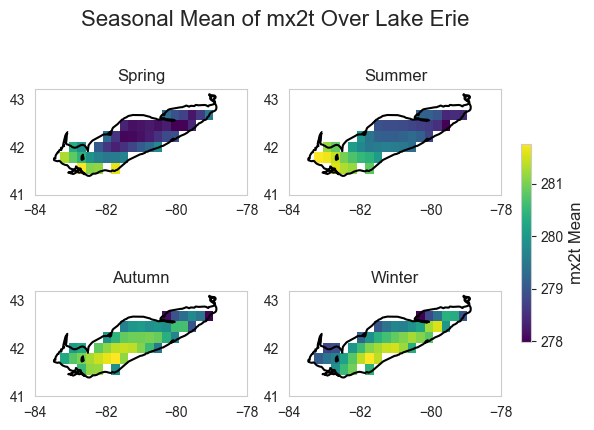

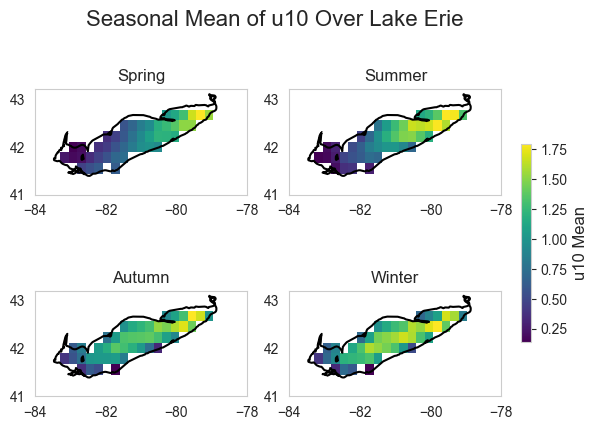

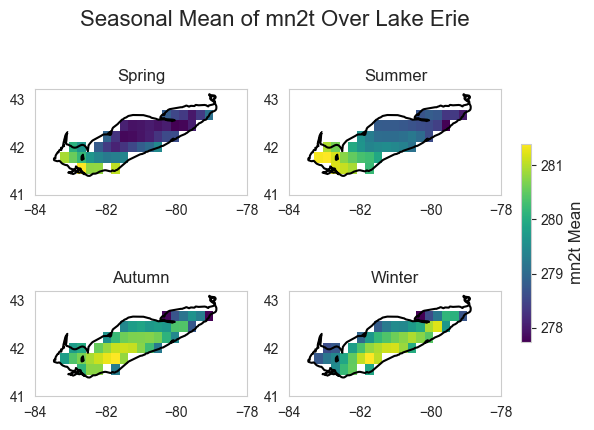

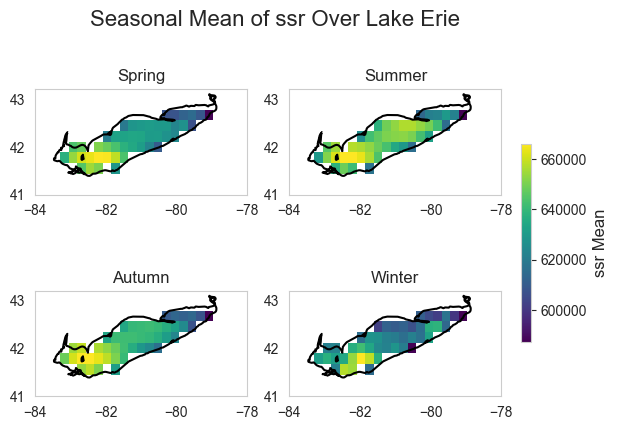

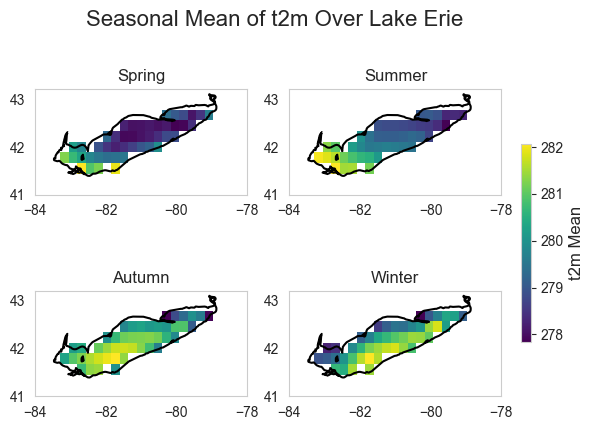

In [4]:
# apply seasons to each parameter
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from rasterio.features import geometry_mask

# Load shapefile
lakes_shapefile = '/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/Lakes_Boundary/ne_10m_lakes.shp'
lakes = gpd.read_file(lakes_shapefile)
lakes = lakes.to_crs(epsg=4326)
lake_erie = lakes.loc[lakes['name'] == 'Lake Erie']

# Load all predictors 
predictor_files = glob("/Users/shenxiaobo/Desktop/PhD Research/WWenSWenCShenJPritchett_CEE506_ESDA_FinalProject/2009_2023_climate/weekly_data/*.nc")

# define seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    

# Function to mask data to the shapefile
def mask_to_shapefile(data_array, shapefile):
    mask = geometry_mask(
        [geom.__geo_interface__ for geom in shapefile.geometry],
        transform=data_array.rio.transform(),
        invert=True,
        out_shape=data_array.shape
    )
    return data_array.where(mask)
    
# take the average seasonal data for each predictor in the past 15 years
seasonal_data = {}

for file in predictor_files:
    # Load the dataset
    ds = xr.open_dataset(file)
    variable_name = list(ds.data_vars)[0]  # Get the variable name

    # Add a season coordinate to the dataset
    ds['season'] = ('valid_time', [assign_season(t) for t in ds['valid_time'].dt.month])

    # Group by season and calculate the mean
    seasonal_mean = ds.groupby('season').mean(dim='valid_time')
    seasonal_data_array = seasonal_mean[variable_name]  # Extract as DataArray

    # Plot seasonal data for the variable
    fig, axs = plt.subplots(2, 2)
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    ims = [] 
    for ax, season in zip(axs.ravel(), seasons):
        # Select the data for the specific season
        season_data = seasonal_data_array.sel(season=season)

        # Mask data to the Lake Erie boundary
        clipped_data = mask_to_shapefile(season_data, lake_erie)

        # Plot the data
        im = ax.imshow(
            clipped_data, cmap='viridis', origin='upper',
            extent=[
                clipped_data.longitude.min().item(), clipped_data.longitude.max().item(),
                clipped_data.latitude.min().item(), clipped_data.latitude.max().item()
            ]
        )
        lake_erie.boundary.plot(ax=ax, edgecolor='black')
        ax.set_title(f"{season}")
        ax.grid(False)
        ims.append(im)
        
    cbar = fig.colorbar(
        ims[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04
    )
    cbar.set_label(f"{variable_name} Mean", fontsize=12)

    # Add a title and save the figure
    plt.suptitle(f"Seasonal Mean of {variable_name} Over Lake Erie", fontsize=16)
    # plt.tight_layout()
    plt.savefig(f"{variable_name}_seasonal_mean.png")
    plt.show()


/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


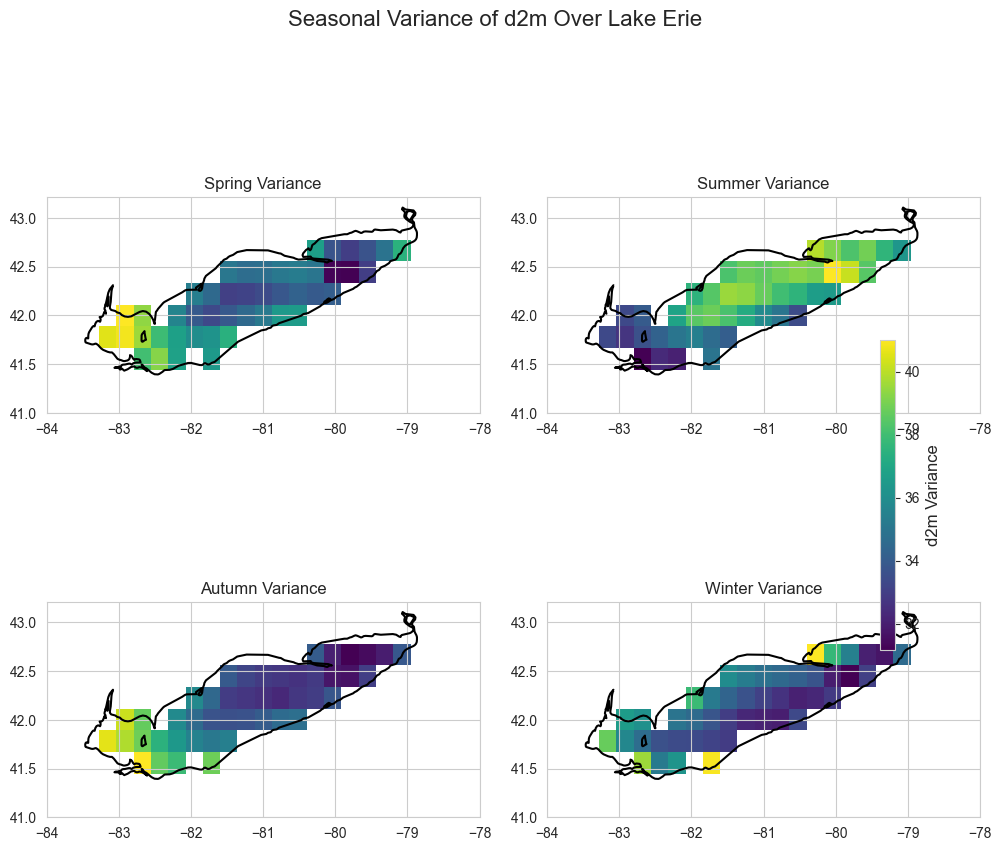

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


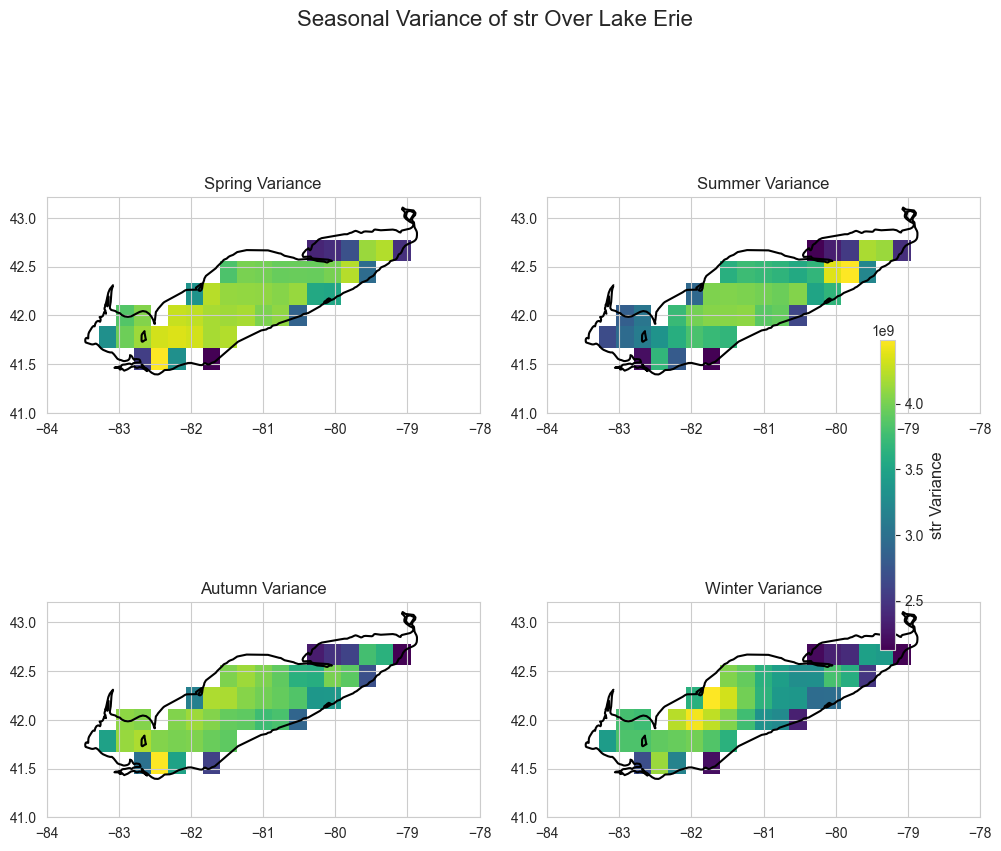

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


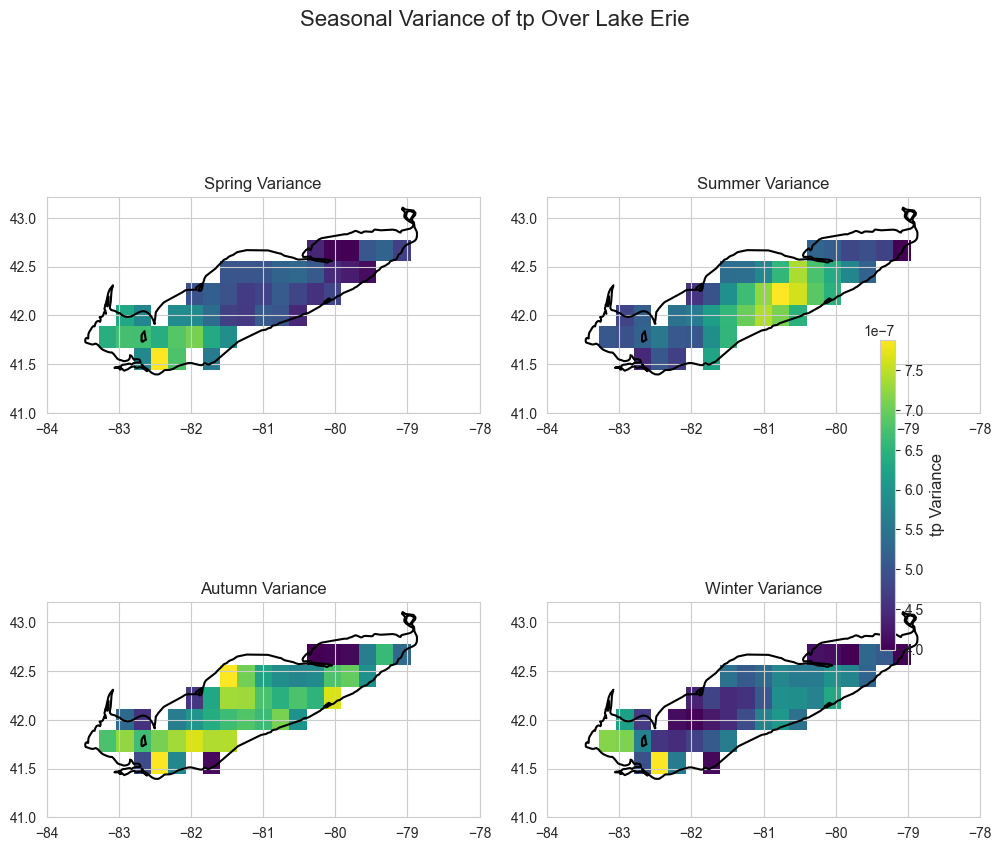

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


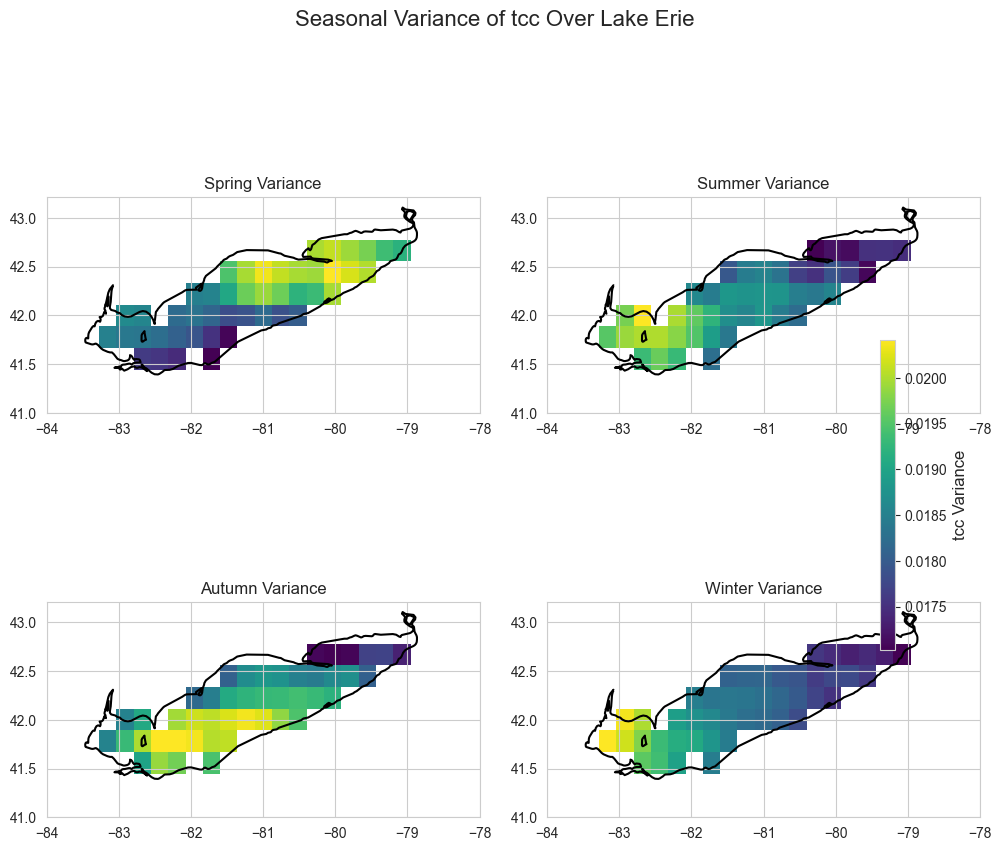

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


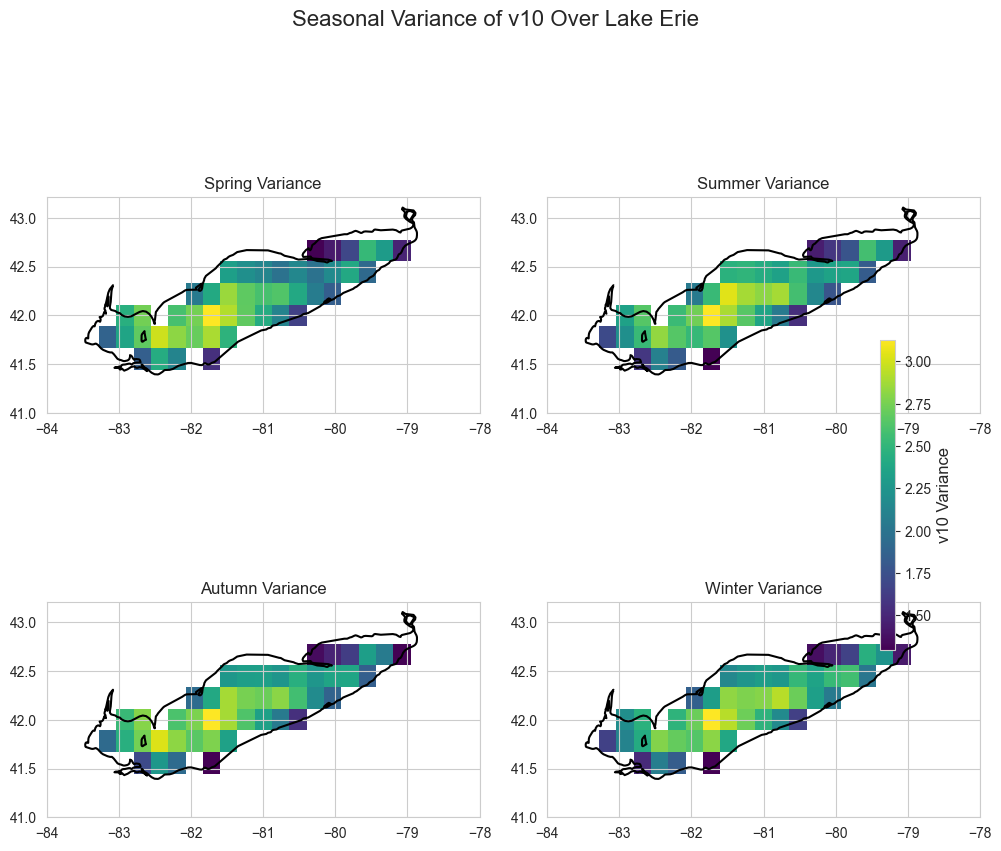

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


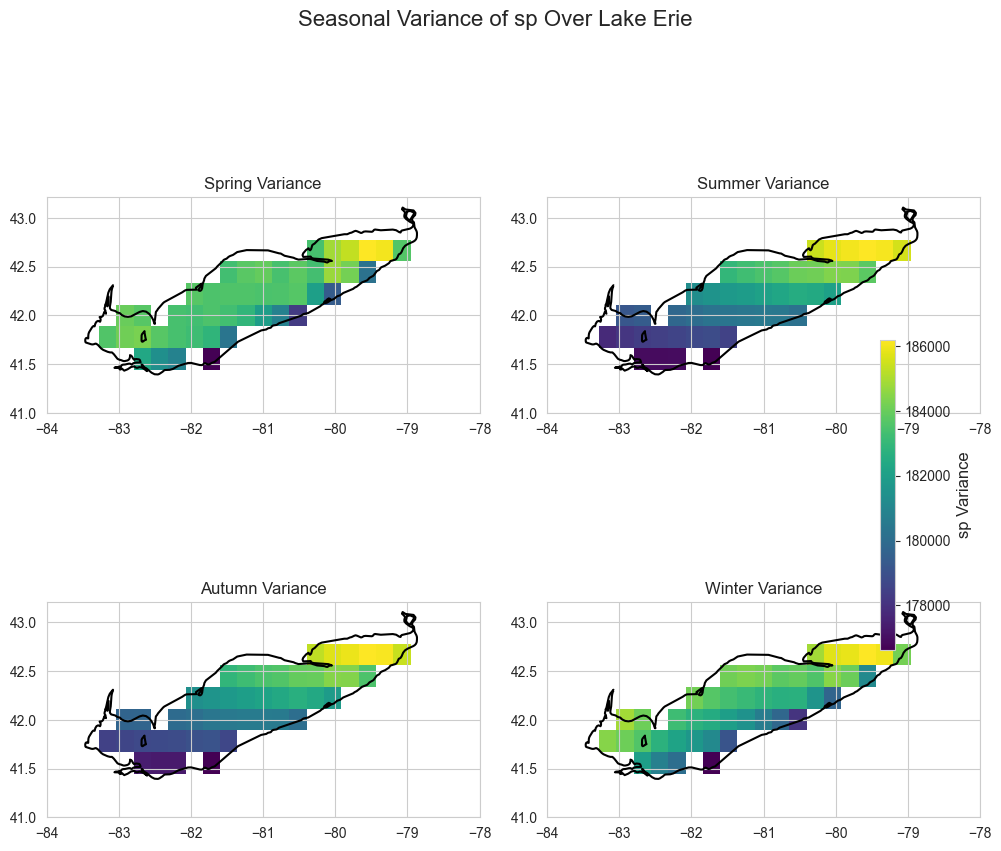

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


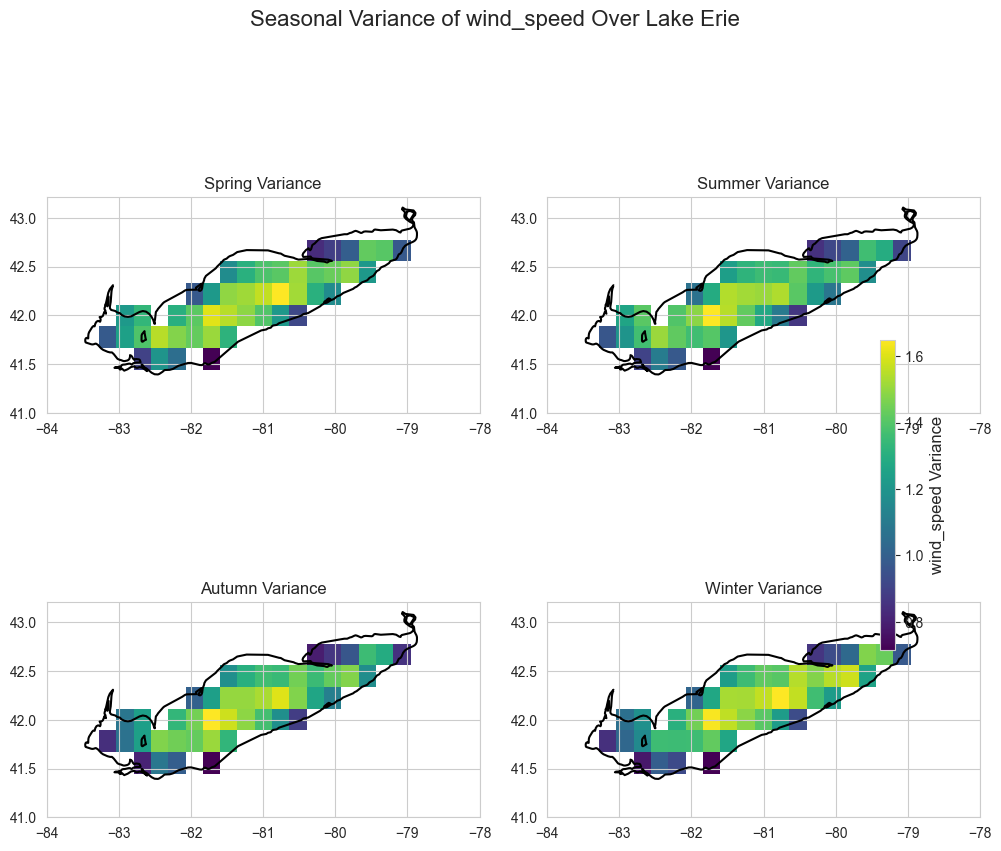

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


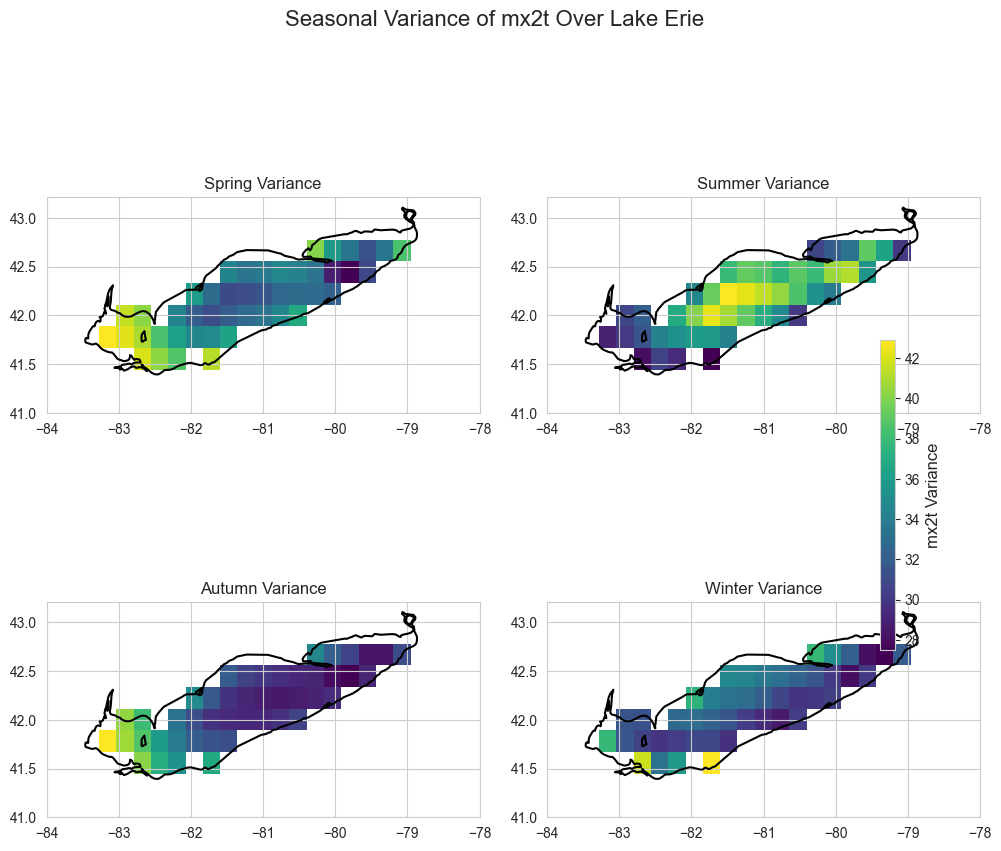

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


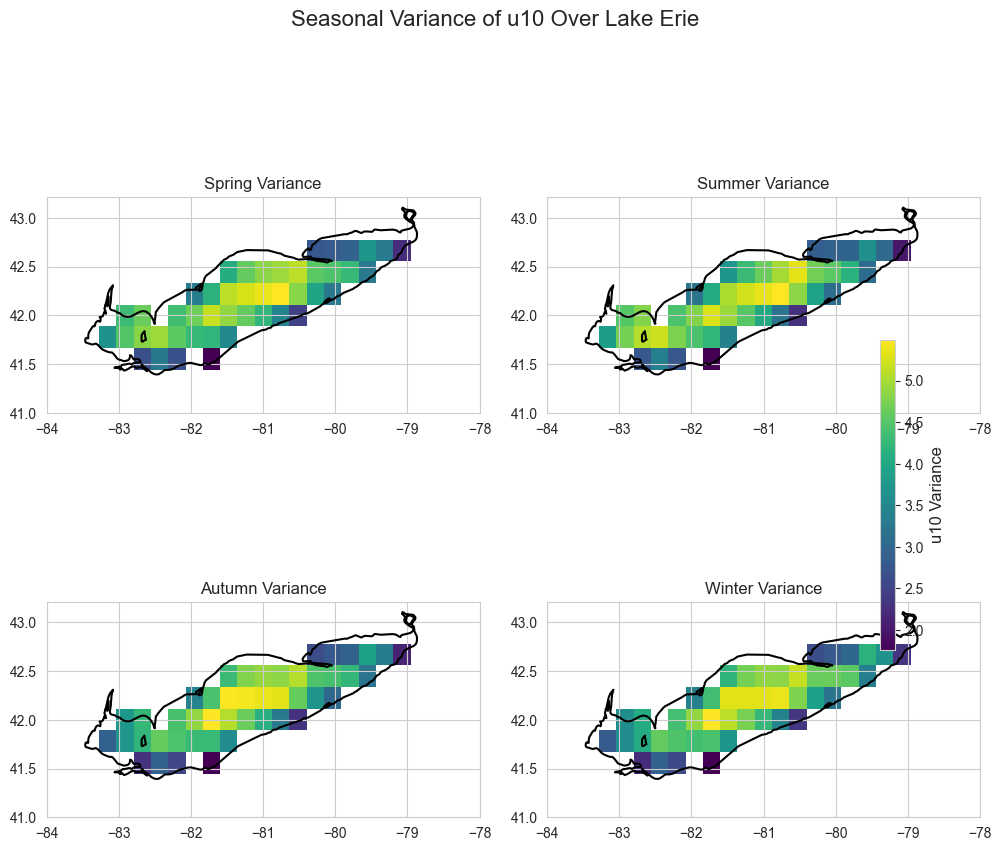

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


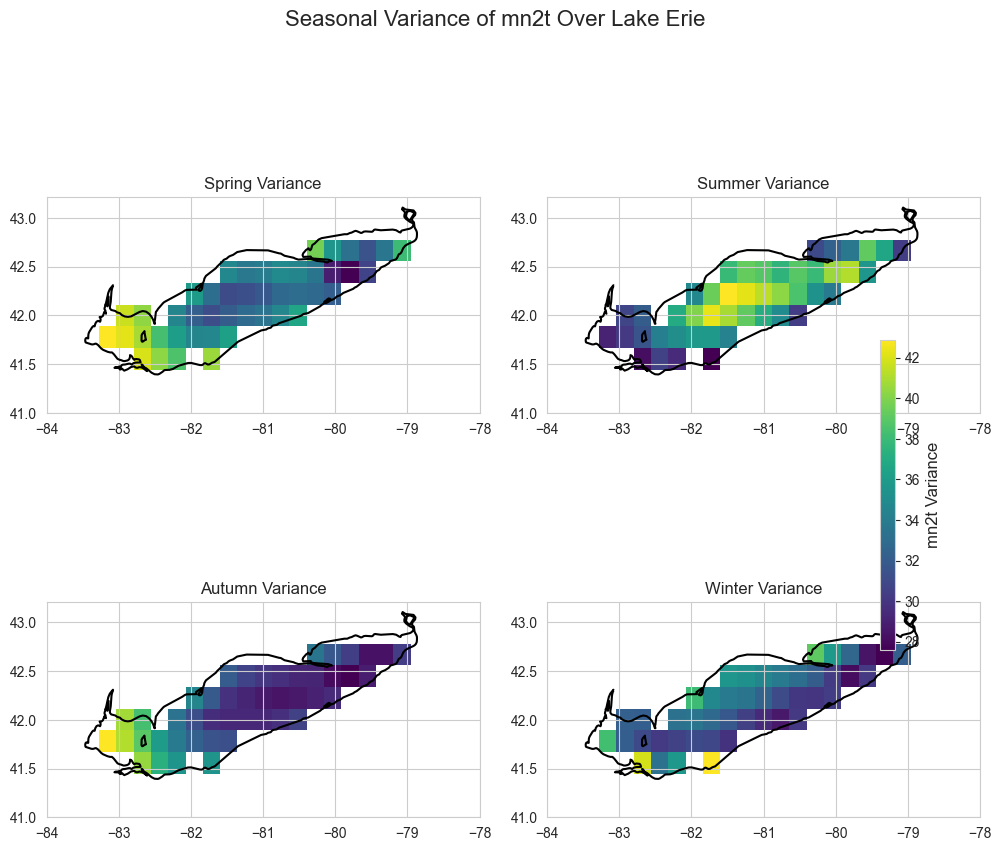

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


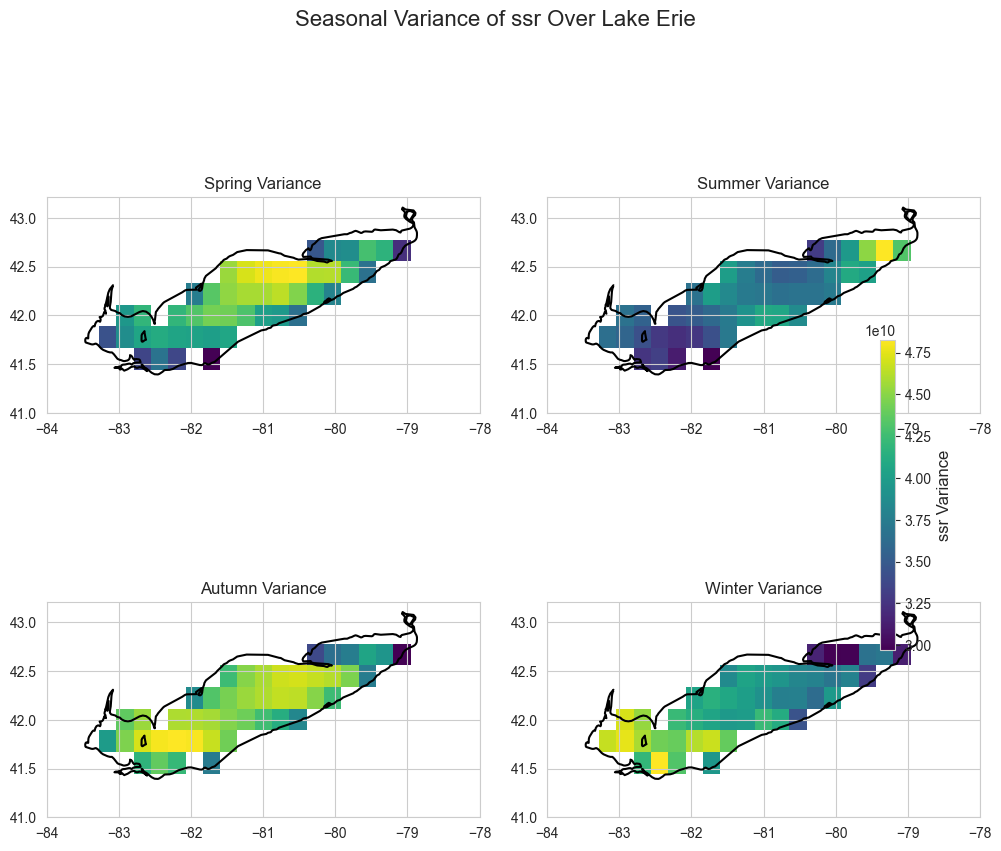

/var/folders/7f/4x3f4byj3dn1rx36mbbzv0xw0000gn/T/ipykernel_4933/2161144339.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


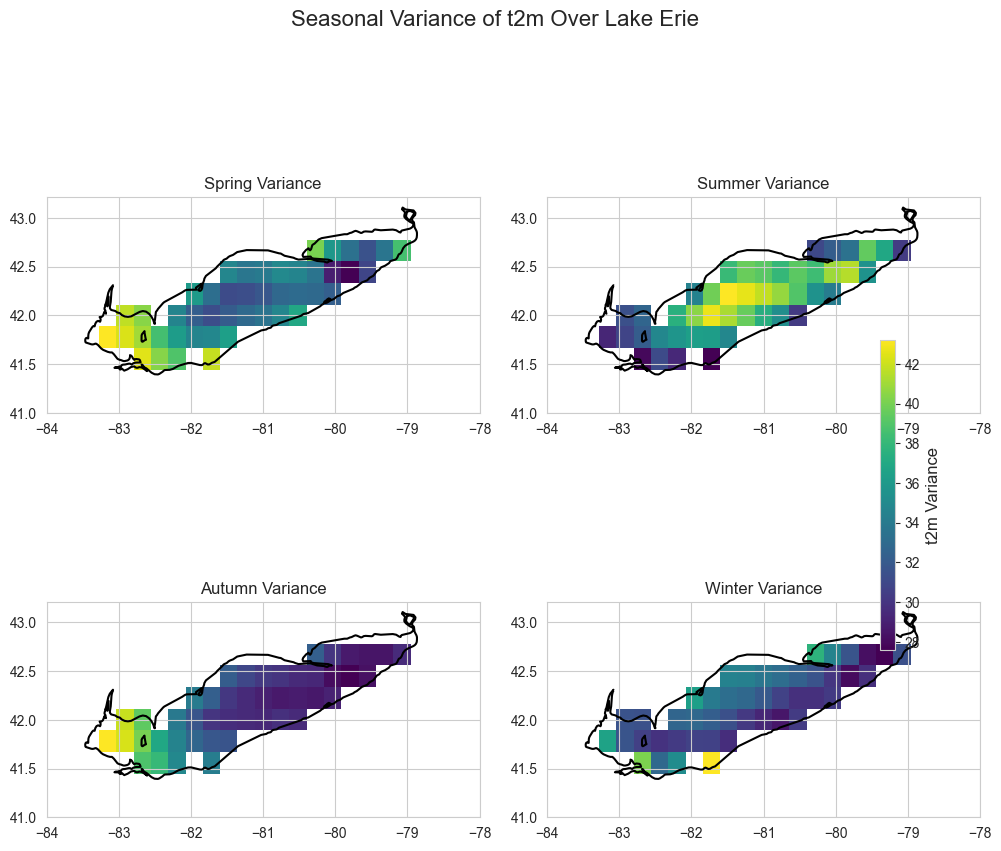

In [3]:
# Function to calculate variance across years
def calculate_seasonal_variance(ds, variable_name):
    # Group by season and calculate variance
    seasonal_variance = ds.groupby('season').var(dim='valid_time')
    return seasonal_variance[variable_name]  # Extract as DataArray

# Iterate through each predictor file
for file in predictor_files:
    # Load the dataset
    ds = xr.open_dataset(file)
    variable_name = list(ds.data_vars)[0]  # Get the variable name

    # Add a season coordinate to the dataset
    ds['season'] = ('valid_time', [assign_season(t) for t in ds['valid_time'].dt.month])

    # Calculate variance grouped by season
    seasonal_variance = calculate_seasonal_variance(ds, variable_name)

    # Plot variance maps for each season
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    ims = []
    for ax, season in zip(axs.ravel(), seasons):
        # Select the variance data for the specific season
        season_variance = seasonal_variance.sel(season=season)

        # Mask data to the Lake Erie boundary
        clipped_variance = mask_to_shapefile(season_variance, lake_erie)

        # Plot the variance data
        im = ax.imshow(
            clipped_variance, cmap='viridis', origin='upper',
            extent=[
                clipped_variance.longitude.min().item(), clipped_variance.longitude.max().item(),
                clipped_variance.latitude.min().item(), clipped_variance.latitude.max().item()
            ]
        )
        lake_erie.boundary.plot(ax=ax, edgecolor='black')
        ax.set_title(f"{season} Variance")
        ims.append(im)
        

    cbar = fig.colorbar(
        ims[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04
    )
    cbar.set_label(f"{variable_name} Variance", fontsize=12)

    # Add a title and save the figure
    plt.suptitle(f"Seasonal Variance of {variable_name} Over Lake Erie", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{variable_name}_seasonal_variance.png")
    plt.show()


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  7.44it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.13it/s]


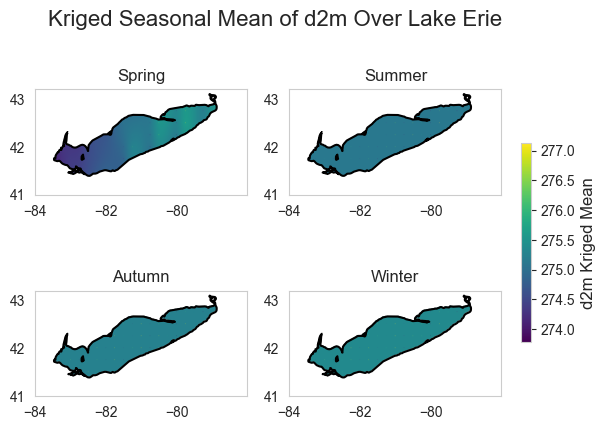

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00, 10.02it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.06it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  7.13it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


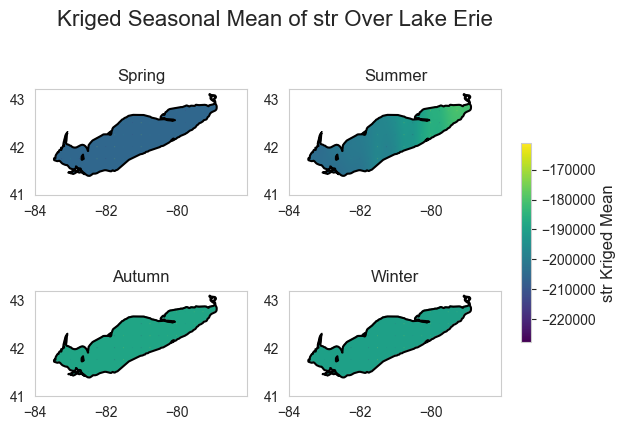

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.22it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.84it/s]


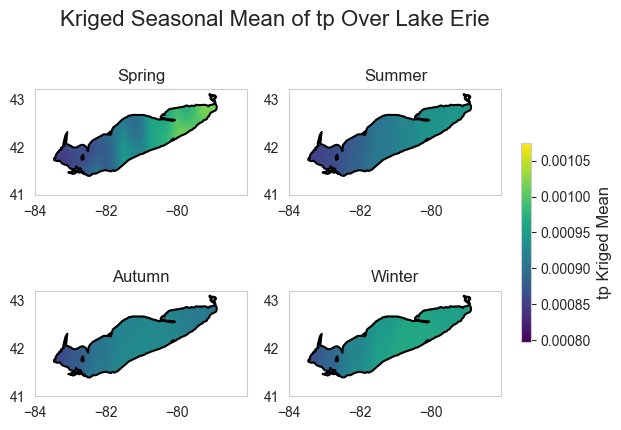

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]


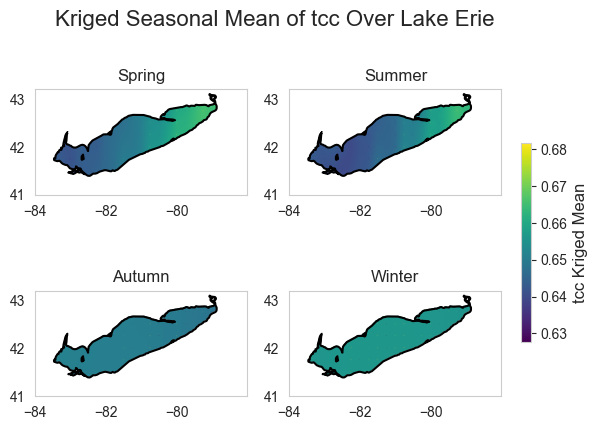

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.42it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.16it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.52it/s]


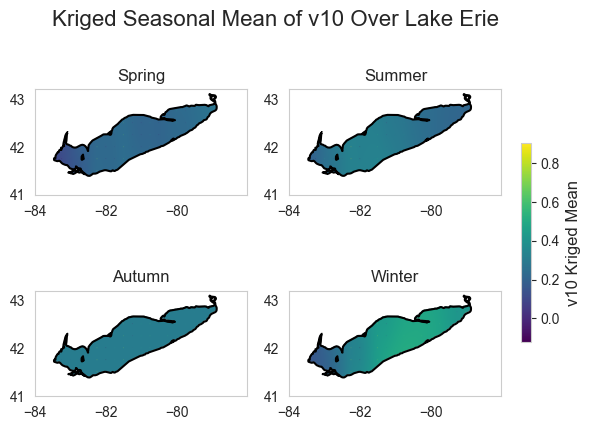

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.65it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.94it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.53it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


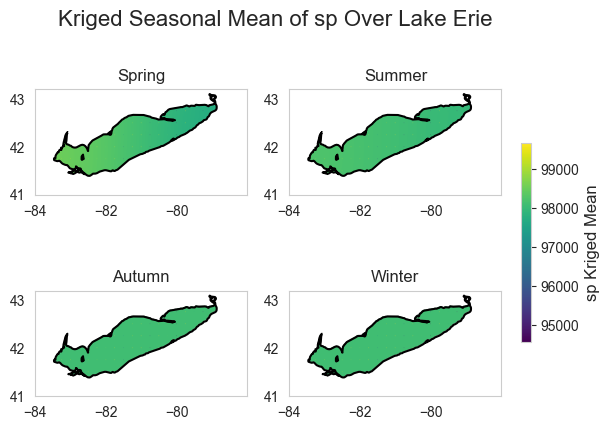

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.63it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.05it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]


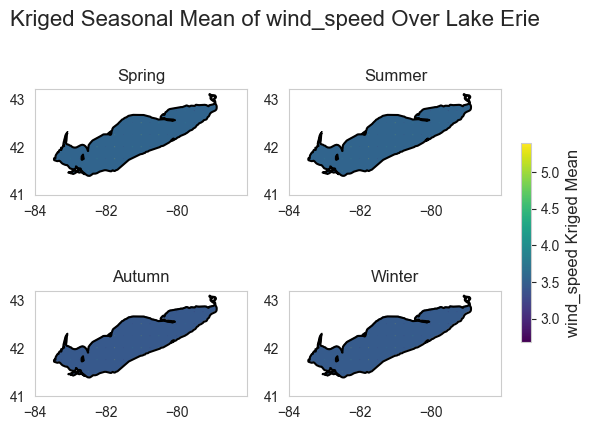

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


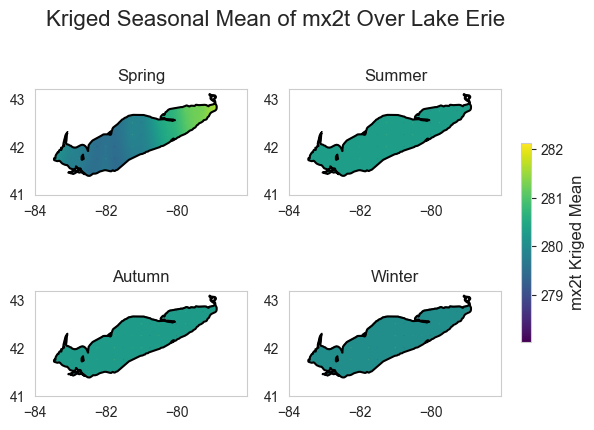

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.17it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  7.77it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  7.60it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.05it/s]


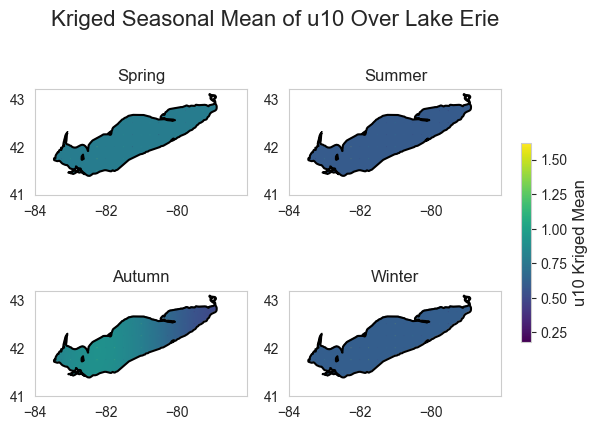

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.77it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.00it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.67it/s]


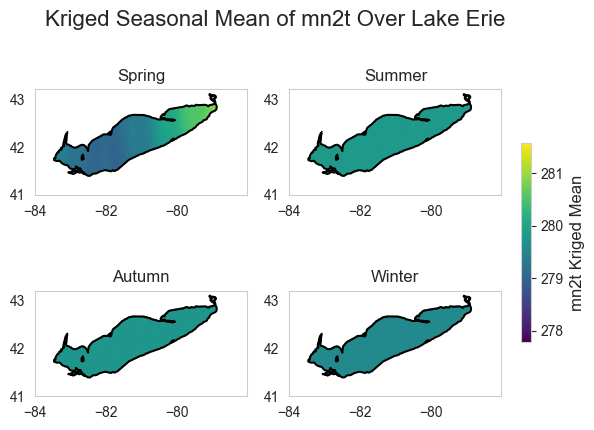

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.00it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.65it/s]


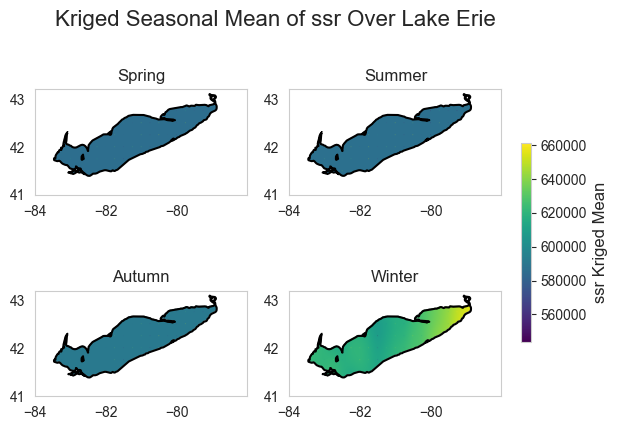

Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.83it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Starting kriging computation...


Processing chunks: 100%|██████████| 6/6 [00:00<00:00,  8.40it/s]


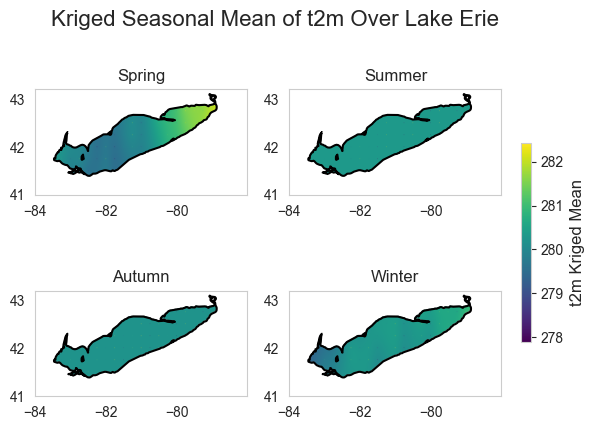

In [6]:
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm

# Function to apply kriging interpolation
def apply_kriging_in_chunks(data_array, grid_x, grid_y, chunk_size=50):
    """
    Apply kriging interpolation in chunks to improve efficiency and track progress.
    Parameters:
        data_array (xr.DataArray): Input 2D DataArray for interpolation.
        grid_x (ndarray): 1D array of x-coordinates for the interpolation grid.
        grid_y (ndarray): 1D array of y-coordinates for the interpolation grid.
        chunk_size (int): Number of grid points to process per chunk.
    Returns:
        xr.DataArray: Kriged DataArray.
    """
    # Extract coordinates and values
    lat, lon = np.meshgrid(data_array.latitude.values, data_array.longitude.values)
    values = data_array.values.ravel()

    # Remove NaN values
    valid = ~np.isnan(values)
    lat, lon, values = lat.ravel()[valid], lon.ravel()[valid], values[valid]

    # Initialize kriging
    kriging = OrdinaryKriging(lon, lat, values, variogram_model="linear", verbose=False, enable_plotting=False)

    # Prepare empty grid
    grid_z = np.empty((len(grid_y), len(grid_x)))
    grid_z[:] = np.nan  # Initialize with NaNs

    # Chunked computation with tqdm
    total_chunks = len(grid_x) * len(grid_y) // chunk_size
    print("Starting kriging computation...")
    for i in tqdm(range(0, len(grid_x), chunk_size), desc="Processing chunks"):
        for j in range(0, len(grid_y), chunk_size):
            # Define grid chunk
            x_chunk = grid_x[i : i + chunk_size]
            y_chunk = grid_y[j : j + chunk_size]

            if len(x_chunk) > 0 and len(y_chunk) > 0:
                # Perform kriging for the chunk
                chunk_z, _ = kriging.execute("grid", x_chunk, y_chunk)
                # Assign results to the grid
                grid_z[j : j + len(y_chunk), i : i + len(x_chunk)] = chunk_z

    # Convert to DataArray
    kriged_data = xr.DataArray(grid_z, coords=[grid_y, grid_x], dims=["latitude", "longitude"])
    return kriged_data

def generate_interpolation_grid(data_array, resolution=0.01):
    """
    Generate a grid for kriging interpolation.
    Parameters:
        data_array (xr.DataArray): Input data array.
        resolution (float): Grid resolution in degrees.
    Returns:
        ndarray, ndarray: 1D arrays of latitude and longitude.
    """
    lat_min, lat_max = data_array.latitude.min().item(), data_array.latitude.max().item()
    lon_min, lon_max = data_array.longitude.min().item(), data_array.longitude.max().item()
    grid_lat = np.arange(lat_min, lat_max, resolution)
    grid_lon = np.arange(lon_min, lon_max, resolution)
    return grid_lon, grid_lat

# Iterate through each predictor file
for file in predictor_files:
    # Load the dataset
    ds = xr.open_dataset(file)
    variable_name = list(ds.data_vars)[0]  # Get the variable name

    # Add a season coordinate to the dataset
    ds['season'] = ('valid_time', [assign_season(t) for t in ds['valid_time'].dt.month])

    # Group by season and calculate the mean
    seasonal_mean = ds.groupby('season').mean(dim='valid_time')
    seasonal_data_array = seasonal_mean[variable_name]  # Extract as DataArray

    # Generate interpolation grid
    grid_x, grid_y = generate_interpolation_grid(seasonal_data_array)

    # Plot kriged seasonal data for the variable
    fig, axs = plt.subplots(2, 2)
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    ims = [] 
    for ax, season in zip(axs.ravel(), seasons):
        # Select the data for the specific season
        season_data = seasonal_data_array.sel(season=season)

        # Apply Kriging interpolation with chunks
        kriged_data = apply_kriging_in_chunks(season_data, grid_x, grid_y, chunk_size=100)

        # Mask kriged data to the Lake Erie boundary
        clipped_data = mask_to_shapefile(kriged_data, lake_erie)

        # Plot the kriged data
        im = ax.imshow(
            clipped_data, cmap='viridis', origin='lower',
            extent=[
                clipped_data.longitude.min().item(), clipped_data.longitude.max().item(),
                clipped_data.latitude.min().item(), clipped_data.latitude.max().item()
            ]
        )
        lake_erie.boundary.plot(ax=ax, edgecolor='black')
        ax.set_title(f"{season}")
        ax.grid(False)
        ims.append(im)
        
    cbar = fig.colorbar(
        ims[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04
    )
    cbar.set_label(f"{variable_name} Kriged Mean", fontsize=12)

    # Add a title and save the figure
    plt.suptitle(f"Kriged Seasonal Mean of {variable_name} Over Lake Erie", fontsize=16)
    plt.savefig(f"{variable_name}_kriged_seasonal_mean.png")
    plt.show()


## Temporal analysis 
